<a href="https://colab.research.google.com/github/aidowu1/graphMERT-python/blob/main/graphMERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphMERT Training Notebook
This notebook trains a Heterogeneous Graph Attention Transformer (GraphMERT) using PyTorch.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json

### Load Corpus and encode with SentenceTransformer - SBERT

 corpus is from Romeo and Juliet for free from gutenberg:
 https://www.gutenberg.org/ebooks/1513.txt.utf-8

 Data will be downloaded usig:
 ! wget https://www.gutenberg.org/ebooks/1513.txt.utf-8

In [2]:
 ! wget https://www.gutenberg.org/ebooks/1513.txt.utf-8 -O pg_sample_book.txt

--2026-02-08 21:10:41--  https://www.gutenberg.org/ebooks/1513.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/1513/pg1513.txt [following]
--2026-02-08 21:10:41--  http://www.gutenberg.org/cache/epub/1513/pg1513.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/cache/epub/1513/pg1513.txt [following]
--2026-02-08 21:10:41--  https://www.gutenberg.org/cache/epub/1513/pg1513.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169546 (166K) [text/plain]
Saving to: ‘pg_sample_book.txt’

pg_sample_book.txt  100%[===================>] 165.57K  

In [3]:

import json
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import numpy as np

# Load Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Split into sentences (a simple approach)
# import nltk
# nltk.download('punkt')
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')


from nltk import sent_tokenize

# Load large text corpus from a .txt file (e.g., downloaded from Project Gutenberg)
with open("/content/pg_sample_book.txt", "r", encoding="utf-8") as file:
    text = file.read()

sentences = sent_tokenize(text)

# Now you can use sentences as your corpus list instead of a small example list
corpus = sentences


# Example corpus with at least 10 sentences
# corpus = [
#     "Deep learning models revolutionize AI research.",
#     "Graph neural networks effectively process relational data.",
#     "Natural language processing benefits from transformers.",
#     "PyTorch offers dynamic computation graphs.",
#     "Embedding layers convert tokens into vectors."
# ]

seq_len = 5
original_dim = model.get_sentence_embedding_dimension()  # Typically 384
target_dim = 10  # as per your JSON structure

# Step 1: Encode all sentences using the Sentence Transformer
embeddings = model.encode(corpus)

# Step 2: Reduce 384-dim embeddings to 10-dim using PCA
pca = PCA(n_components=target_dim)
reduced_embeddings = pca.fit_transform(embeddings)

graphs = []
num_graphs = (len(reduced_embeddings) + seq_len - 1) // seq_len

for i in range(num_graphs):
    start = i * seq_len
    end = min(len(reduced_embeddings), (i + 1) * seq_len)
    chunk = reduced_embeddings[start:end].tolist()

    # Pad with zero vectors if less than seq_len
    while len(chunk) < seq_len:
        chunk.append([0.0] * target_dim)

    # Labels matching your example pattern (length=5)
    if i == 0:
        labels = [1, 0, 2, 1, 0]
    else:
        labels = [0, 1, 0, 2, 1]

    graphs.append({
        "features": chunk,
        "labels": labels
    })

# Save final dataset JSON exactly like your example structure
with open("sentence_transformer_fixed10d_graphs.json", "w") as f:
    json.dump(graphs, f, indent=2)

print(f"Saved {len(graphs)} graph examples to sentence_transformer_fixed10d_graphs.json")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Saved 634 graph examples to sentence_transformer_fixed10d_graphs.json


### Run Training

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# H-GAT Layer with consistent dims
class HeteroGraphAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.linear = nn.Linear(embed_dim, embed_dim)
        self.attention_heads = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim // num_heads, num_heads=1, batch_first=True)
            for _ in range(num_heads)
        ])

    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        x_proj = self.linear(x)
        splits = torch.chunk(x_proj, self.num_heads, dim=-1)
        head_outputs = []
        for split, attn in zip(splits, self.attention_heads):
            out, _ = attn(split, split, split)
            head_outputs.append(out)
        return torch.cat(head_outputs, dim=-1)

# GraphMERT Encoder
class GraphMERTEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_layers, num_heads):
        super().__init__()
        self.total_embed_dim = embed_dim * num_heads
        self.embedding = nn.Linear(input_dim, self.total_embed_dim)
        self.hgat_layers = nn.ModuleList([
            HeteroGraphAttentionLayer(self.total_embed_dim, num_heads=num_heads)
            for _ in range(num_layers)
        ])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.total_embed_dim, nhead=num_heads, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.embedding(x)
        for hgat in self.hgat_layers:
            x = hgat(x)
        x = self.transformer_encoder(x)
        return x

# Synthetic dataset matching model input/output shapes
# class ChainGraphDataset(Dataset):
#     def __init__(self, num_samples=100, seq_len=5, feature_dim=10, num_classes=10):
#         self.features = torch.randn(num_samples, seq_len, feature_dim)
#         self.labels = torch.randint(0, num_classes, (num_samples, seq_len))

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

class ChainGraphDataset(Dataset):
    def __init__(self, json_path):
        import json
        with open(json_path, 'r') as f:
            self.chain_graphs = json.load(f)

    def __len__(self):
        return len(self.chain_graphs)

    def __getitem__(self, idx):
        example = self.chain_graphs[idx]
        features = torch.tensor(example["features"], dtype=torch.float)
        labels = example.get("labels")
        if labels is not None:
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            labels = torch.full((features.shape[0],), -100, dtype=torch.long)
        return features, labels


# Training loop with loss and optimizer
def train_graphmert(model, dataloader, optimizer, num_epochs, device):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    for epoch in range(num_epochs):
        total_loss = 0
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)  # (batch, seq_len, embed_dim*num_heads)
            logits = outputs.view(-1, outputs.size(-1))
            loss = criterion(logits, labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

if __name__ == "__main__":
    input_dim = 10
    embed_dim = 32
    num_heads = 4  # should be a divisor of total embedding dimension and even for multihead attention
    num_layers = 2
    batch_size = 8
    num_epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # for Synthetic dataset matching model input/output shapes
      # dataset = ChainGraphDataset(num_samples=100, seq_len=5, feature_dim=input_dim, num_classes=10)
      # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset = ChainGraphDataset("/content/sentence_transformer_fixed10d_graphs.json")
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    model = GraphMERTEncoder(input_dim, embed_dim, num_layers, num_heads)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_graphmert(model, dataloader, optimizer, num_epochs, device)

    # Save the trained model weights
    save_path = "graphmert_model.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    class_head = nn.Linear(embed_dim * num_heads, 5)  # 5 classes

    torch.save(class_head.state_dict(), "graphmert_classifier_head.pth")
    print(f"class_head Model saved to graphmert_classifier_head.pth")



Epoch 1/50, Loss: 1.2273
Epoch 2/50, Loss: 1.1282
Epoch 3/50, Loss: 1.1021
Epoch 4/50, Loss: 1.0903
Epoch 5/50, Loss: 1.0881
Epoch 6/50, Loss: 1.0809
Epoch 7/50, Loss: 1.0791
Epoch 8/50, Loss: 1.0738
Epoch 9/50, Loss: 1.0701
Epoch 10/50, Loss: 1.0682
Epoch 11/50, Loss: 1.0672
Epoch 12/50, Loss: 1.0648
Epoch 13/50, Loss: 1.0641
Epoch 14/50, Loss: 1.0644
Epoch 15/50, Loss: 1.0615
Epoch 16/50, Loss: 1.0599
Epoch 17/50, Loss: 1.0648
Epoch 18/50, Loss: 1.0651
Epoch 19/50, Loss: 1.0633
Epoch 20/50, Loss: 1.0606
Epoch 21/50, Loss: 1.0614
Epoch 22/50, Loss: 1.0669
Epoch 23/50, Loss: 1.0671
Epoch 24/50, Loss: 1.0609
Epoch 25/50, Loss: 1.0637
Epoch 26/50, Loss: 1.0619
Epoch 27/50, Loss: 1.0588
Epoch 28/50, Loss: 1.0616
Epoch 29/50, Loss: 1.0602
Epoch 30/50, Loss: 1.0599
Epoch 31/50, Loss: 1.0602
Epoch 32/50, Loss: 1.0593
Epoch 33/50, Loss: 1.0571
Epoch 34/50, Loss: 1.0595
Epoch 35/50, Loss: 1.0574
Epoch 36/50, Loss: 1.0598
Epoch 37/50, Loss: 1.0569
Epoch 38/50, Loss: 1.0576
Epoch 39/50, Loss: 1.

### *Inference*

In [5]:
# STEP 1: Load trained model weights
input_dim = 10
embed_dim = 32
num_heads = 4
num_layers = 2
model_path = "/content/graphmert_model.pth"

model = GraphMERTEncoder(input_dim, embed_dim, num_layers, num_heads)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

# STEP 2: Prepare input text corpus to embeddings
# Load large text corpus from a .txt file (e.g., downloaded from Project Gutenberg)
with open("/content/pg_sample_book.txt", "r", encoding="utf-8") as file:
    text = file.read()

sentences = sent_tokenize(text)

# Now you can use sentences as your corpus list instead of a small example list
corpus = sentences

# Use SBERT to get fixed-size embeddings
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(corpus)  # shape approx (5,384)

# STEP 3: Reduce dimension to 10 with PCA (to match input_dim)
n_components = min(input_dim, embeddings.shape[0], embeddings.shape[1])
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings)  # (5,10)

# STEP 4: Convert to tensor and shape (1 batch, 5 nodes, 10 features)
input_features = torch.tensor([reduced_embeddings], dtype=torch.float32)  # Shape: (1,5,10)

# STEP 5: Inference
with torch.no_grad():
    outputs = model(input_features)  # Shape: (1, 5, embed_dim * num_heads)
    print("Inference output shape:", outputs.shape)
    print("Inference output tensor:", outputs)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/tmp/ipython-input-3608249009.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  input_features = torch.tensor([reduced_embeddings], dtype=torch.float32)  # Shape: (1,5,10)


Inference output shape: torch.Size([1, 3166, 128])
Inference output tensor: tensor([[[ 7.3642,  7.3392,  6.6327,  ..., -7.7088, -8.2455, -8.0945],
         [ 7.3642,  7.3392,  6.6327,  ..., -7.7088, -8.2455, -8.0945],
         [ 7.3642,  7.3392,  6.6327,  ..., -7.7088, -8.2455, -8.0945],
         ...,
         [ 7.3642,  7.3392,  6.6327,  ..., -7.7088, -8.2455, -8.0945],
         [ 7.3642,  7.3392,  6.6327,  ..., -7.7088, -8.2455, -8.0945],
         [ 7.3642,  7.3392,  6.6327,  ..., -7.7088, -8.2455, -8.0945]]])


In [6]:
# Assuming 'corpus' is your list of input sentences or text chunks fed to the model
outputs_np = outputs[0].cpu().numpy()  # shape: (3166, 128)

for idx, embedding in enumerate(outputs_np):
    text_unit = corpus[idx]  # original text corresponding to node idx
    print(f"Text unit #{idx}: {text_unit}")
    print(f"Embedding vector sample: {embedding[:5]}...")  # show first 5 dims for brevity


Streaming output truncated to the last 5000 lines.
Text unit #1315: [_Exeunt._]

SCENE V. Capulet’s Garden.
Embedding vector sample: [ 7.364208   7.3392076  6.6326547 -8.626296  -8.518253 ]...
Text unit #1316: Enter Juliet.
Embedding vector sample: [ 7.364208   7.3392076  6.6326547 -8.626296  -8.518253 ]...
Text unit #1317: JULIET.
Embedding vector sample: [ 7.364208   7.3392076  6.6326547 -8.626296  -8.518253 ]...
Text unit #1318: The clock struck nine when I did send the Nurse,
In half an hour she promised to return.
Embedding vector sample: [ 7.3642077  7.3392076  6.6326547 -8.626296  -8.518253 ]...
Text unit #1319: Perchance she cannot meet him.
Embedding vector sample: [ 7.364208   7.3392076  6.6326547 -8.626296  -8.518253 ]...
Text unit #1320: That’s not so.
Embedding vector sample: [ 7.3642097  7.3392096  6.6326556 -8.626296  -8.518253 ]...
Text unit #1321: O, she is lame.
Embedding vector sample: [ 7.364208   7.3392076  6.6326547 -8.626296  -8.518253 ]...
Text unit #1322: Love’

## Analysis of GraphMERT KG created model

### Perform classification on output embeddings

In [7]:
import torch
import torch.nn as nn

# Assume `outputs` is your GraphMERT encoder inference output with shape (1, N, 128)
# and `corpus` is your list of N text inputs (sentences, nodes, etc.)
# Example:
# outputs = model(input_features)
# corpus = ["sentence 1", "sentence 2", ..., "sentence N"]

num_classes = 5  # number of categories you want the head to predict

# Create (or load) classifier head
class_head = nn.Linear(128, num_classes)  # 128 matches your embedding dimension
# optional: if fine-tuned head weights exist
# class_head.load_state_dict(torch.load("graphmert_classifier_head.pth", map_location="cpu"))
class_head.eval()

# Step 1. Feed GraphMERT embeddings into the head
with torch.no_grad():
    logits = class_head(outputs.squeeze(0))  # shape: (num_nodes, num_classes)
    preds = torch.argmax(logits, dim=-1)

# Step 2. Match predictions with corresponding text
# for idx, label in enumerate(preds.tolist()):
#     print(f"Sentence #{idx}: {corpus[idx]} --> Predicted class: {label}")

probs = torch.softmax(logits, dim=-1)
for idx, (label, confidence) in enumerate(zip(preds.tolist(), probs.max(dim=-1).values.tolist())):
    print(f"{corpus[idx]} --> Predicted class {label} (confidence {confidence:.2f})")


﻿The Project Gutenberg eBook of Romeo and Juliet
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. --> Predicted class 0 (confidence 0.46)
You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. --> Predicted class 0 (confidence 0.46)
If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook. --> Predicted class 0 (confidence 0.46)
Title: Romeo and Juliet

Author: William Shakespeare

Release date: November 1, 1998 [eBook #1513]
                Most recently updated: September 18, 2025

Language: English

Credits: the PG Shakespeare Team, a team of about twenty Project Gutenberg volunteers


*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***




THE TRAGEDY OF ROMEO AND JULIET

by William Shakespe

In [8]:
import torch.nn as nn
import torch

# Example: add a simple classifier for N classes
num_classes = 5
class_head = nn.Linear(128, num_classes)  # assuming 128-dim embeddings
class_head.load_state_dict(torch.load("/content/graphmert_classifier_head.pth"))  # optional fine-tuned head
class_head.eval()

# Perform classification on output embeddings
with torch.no_grad():
    logits = class_head(outputs.squeeze(0))  # shape: (num_nodes, num_classes)
    preds = torch.argmax(logits, dim=-1)

# Map predictions to text
for idx, label in enumerate(preds.tolist()):
    print(f"Sentence #{idx}: {corpus[idx]} --> Predicted class: {label}")


Sentence #0: ﻿The Project Gutenberg eBook of Romeo and Juliet
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. --> Predicted class: 2
Sentence #1: You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. --> Predicted class: 2
Sentence #2: If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook. --> Predicted class: 2
Sentence #3: Title: Romeo and Juliet

Author: William Shakespeare

Release date: November 1, 1998 [eBook #1513]
                Most recently updated: September 18, 2025

Language: English

Credits: the PG Shakespeare Team, a team of about twenty Project Gutenberg volunteers


*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***




THE TRAGEDY OF ROMEO AND JULIET

by William Shakesp

### Display representative texts per cluster

In [9]:
from sklearn.cluster import KMeans

embeddings = outputs[0].cpu().numpy()
n_clusters = 10  # choose based on data scale
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
labels = kmeans.labels_

# Display representative texts per cluster
for cluster_id in range(n_clusters):
    cluster_texts = [corpus[i] for i in range(len(corpus)) if labels[i] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_texts)} items):")
    for text in cluster_texts[:3]:
        print("  ", text)



Cluster 0 (126 items):
   BALTHASAR, servant to Romeo.
   FRIAR LAWRENCE, a Franciscan.
   THE PROLOGUE


 Enter Chorus.

Cluster 1 (120 items):
   A Street.
   Scene I.
   Scene V. Juliet’s Chamber; Juliet on the bed.

Cluster 2 (212 items):
   Scene IV.
   Scene II.
   Friar Lawrence’s Cell.

Cluster 3 (0 items):

Cluster 4 (217 items):
   A Street.
   A Street.
   A Street.

Cluster 5 (210 items):
   Title: Romeo and Juliet

Author: William Shakespeare

Release date: November 1, 1998 [eBook #1513]
                Most recently updated: September 18, 2025

Language: English

Credits: the PG Shakespeare Team, a team of about twenty Project Gutenberg volunteers


*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***




THE TRAGEDY OF ROMEO AND JULIET

by William Shakespeare




Contents

THE PROLOGUE.
   Scene III.
   Scene III.

Cluster 6 (191 items):
   A public place.
   Scene III.
   Hall in Capulet’s House.

Cluster 7 (84 items):
   CAPULET.
   CAPULET.
   It was.

Clust

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


### GraphMERT Node Embeddings (t-SNE View)

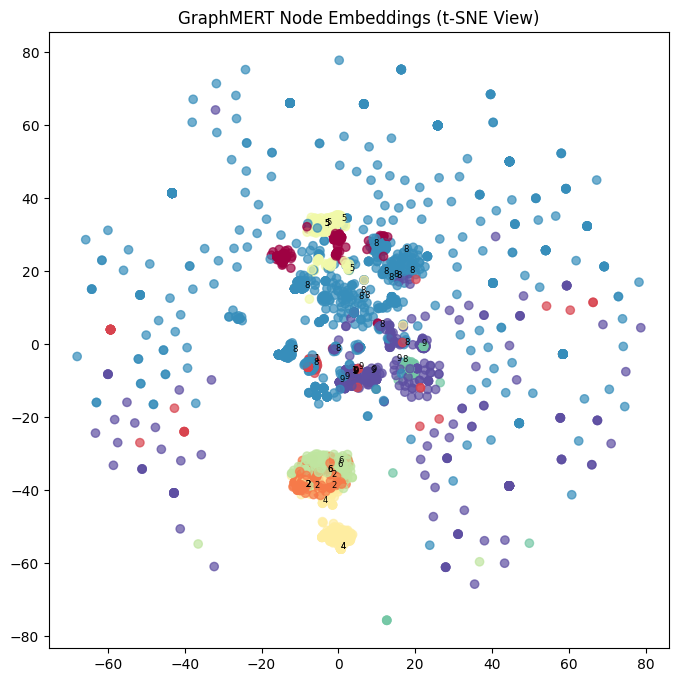

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='Spectral', alpha=0.7)
for i, text in enumerate(corpus[:50]):  # optional show partial labels
    plt.text(emb_2d[i,0]+0.01, emb_2d[i,1]+0.01, str(labels[i]), fontsize=6)
plt.title("GraphMERT Node Embeddings (t-SNE View)")
plt.show()


### GraphMERT Semantic Graph Visualization

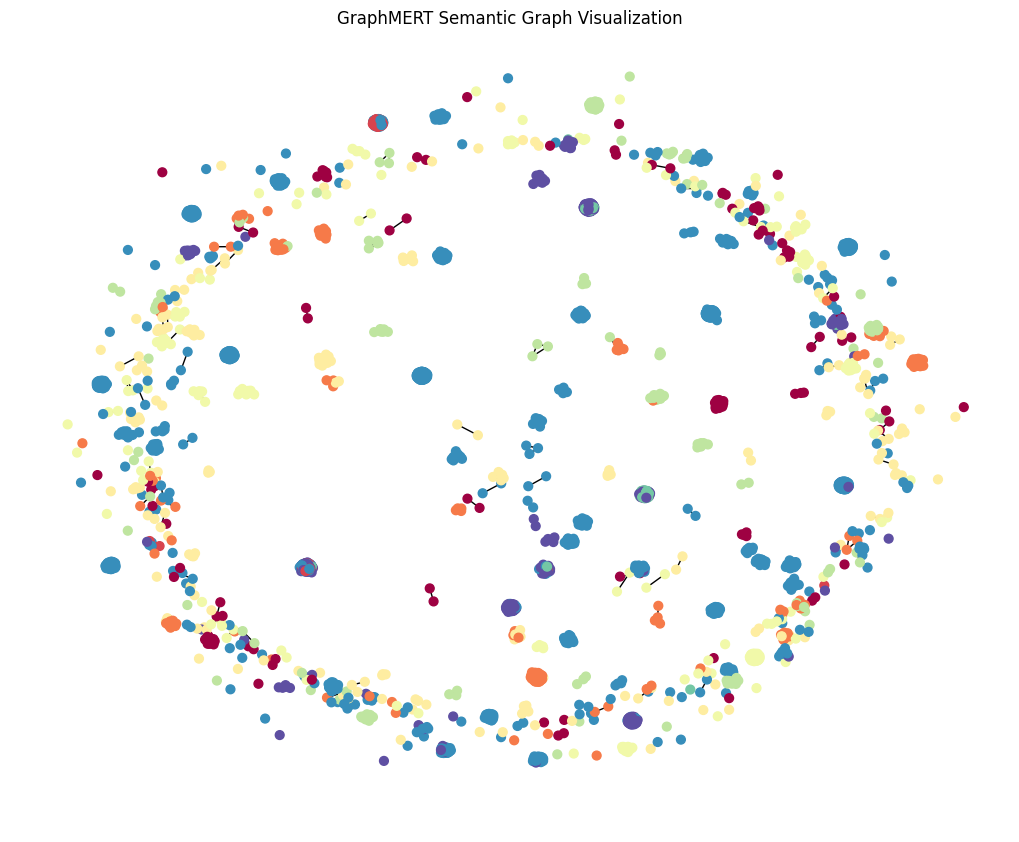

In [11]:
import networkx as nx

G = nx.Graph()
for i, emb in enumerate(embeddings):
    G.add_node(i, text=corpus[i], cluster=int(labels[i]))

# Example: connect close embeddings
from scipy.spatial.distance import pdist, squareform
dist = squareform(pdist(embeddings))
threshold = np.percentile(dist, 5)
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        if dist[i,j] < threshold:
            G.add_edge(i, j)

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=labels, cmap='Spectral', with_labels=False, node_size=40)
plt.title("GraphMERT Semantic Graph Visualization")
plt.show()


In [12]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# List nodes and edges
print("Nodes:", list(G.nodes(data=True))[:10])  # show first 10 with attributes
print("Edges:", list(G.edges(data=True))[:10])


Number of nodes: 3166
Number of edges: 122438
Nodes: [(0, {'text': '\ufeffThe Project Gutenberg eBook of Romeo and Juliet\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever.', 'cluster': 8}), (1, {'text': 'You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this ebook or online\nat www.gutenberg.org.', 'cluster': 9}), (2, {'text': 'If you are not located in the United States,\nyou will have to check the laws of the country where you are located\nbefore using this eBook.', 'cluster': 8}), (3, {'text': 'Title: Romeo and Juliet\n\nAuthor: William Shakespeare\n\nRelease date: November 1, 1998 [eBook #1513]\n                Most recently updated: September 18, 2025\n\nLanguage: English\n\nCredits: the PG Shakespeare Team, a team of about twenty Project Gutenberg volunteers\n\n\n*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AN

In [13]:
# Get all neighbors of a node
node = list(G.nodes())[0]
print(f"Neighbors of {node}:", list(G.neighbors(node)))

# Check if two text nodes are connected
print(G.has_edge("sentence_12", "sentence_29"))

# Get edge attributes (e.g. similarity)
print(G.get_edge_data("sentence_12", "sentence_29"))


Neighbors of 0: [1008, 1027, 1108, 1282, 1356, 1644, 1761, 2069, 2585, 2811]
False
None


In [14]:
import networkx as nx

centrality = nx.degree_centrality(G)
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 influential nodes:")
for node, score in top_nodes:
    print(node, "centrality:", score)


Top 5 influential nodes:
86 centrality: 0.0919431279620853
173 centrality: 0.0919431279620853
201 centrality: 0.0919431279620853
315 centrality: 0.0919431279620853
462 centrality: 0.0919431279620853


In [15]:
# # Shortest path between two concept nodes
# path = nx.shortest_path(G, source="sentence_10", target="sentence_50")
# print("Shortest path:", path)

# # Check if graph is fully connected
# print("Is graph connected?", nx.is_connected(G))


In [16]:
# import matplotlib.pyplot as plt

# pos = nx.spring_layout(G, seed=42)

# # Highlight a sentence cluster or subgraph
# sub_nodes = path  # highlight nodes along the shortest path
# node_colors = ['orange' if n in sub_nodes else 'lightblue' for n in G.nodes()]

# nx.draw(
#     G, pos, node_color=node_colors, with_labels=False,
#     node_size=50, edge_color='gray'
# )
# plt.title("Highlighted Knowledge Path in GraphMERT KG")
# plt.show()


In [17]:
#  networkx Semantic Group Queries
for c_id in set(labels):
    cluster_group = [n for n, lbl in zip(G.nodes(), labels) if lbl == c_id]
    print(f"\nCluster {c_id}:")
    for node in cluster_group[:5]:
        print("  ", G.nodes[node].get("text", node))



Cluster 0:
   BALTHASAR, servant to Romeo.
   FRIAR LAWRENCE, a Franciscan.
   THE PROLOGUE


 Enter Chorus.
   Ay, the heads of the maids, or their maidenheads; take it in what sense
thou wilt.
   I do bite my thumb, sir.

Cluster 1:
   A Street.
   Scene I.
   Scene V. Juliet’s Chamber; Juliet on the bed.
   SAMPSON, servant to Capulet.
   FRIAR JOHN, of the same Order.

Cluster 2:
   Scene IV.
   Scene II.
   Friar Lawrence’s Cell.
   Friar Lawrence’s Cell.
   Friar Lawrence’s cell.

Cluster 4:
   A Street.
   A Street.
   A Street.
   MONTAGUE, head of a Veronese family at feud with the Capulets.
   CAPULET’S COUSIN, an old man.

Cluster 5:
   Title: Romeo and Juliet

Author: William Shakespeare

Release date: November 1, 1998 [eBook #1513]
                Most recently updated: September 18, 2025

Language: English

Credits: the PG Shakespeare Team, a team of about twenty Project Gutenberg volunteers


*** START OF THE PROJECT GUTENBERG EBOOK ROMEO AND JULIET ***




THE TRAGEDY 

# Sample GraphMERT RAG **setup**

In [18]:
import torch
import numpy as np
import networkx as nx
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.decomposition import PCA
from nltk.tokenize import sent_tokenize

# Assume GraphMERTEncoder class is defined per your original code

# --- Load GraphMERT model ---
input_dim = 10
embed_dim = 32
num_heads = 4
num_layers = 2
model_path = "/content/graphmert_model.pth"

model = GraphMERTEncoder(input_dim, embed_dim, num_layers, num_heads)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

# --- Load and prepare corpus ---
with open("/content/pg_sample_book.txt", "r", encoding="utf-8") as f:
    text = f.read()

corpus = sent_tokenize(text)

# --- Embed with SBERT and reduce with PCA ---
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_embeddings = sbert_model.encode(corpus)  # (N, 384)

pca_text = PCA(n_components=input_dim)
reduced_sbert_emb = pca_text.fit_transform(sbert_embeddings)  # (N, 10)

# --- Prepare inputs and run GraphMERT inference ---
input_features = torch.tensor([reduced_sbert_emb], dtype=torch.float32)  # (1, N, 10)
with torch.no_grad():
    graphmert_outputs = model(input_features)  # (1, N, 128)
graphmert_embeddings = graphmert_outputs[0].cpu().numpy()

# --- Reduce GraphMERT embeddings with separate PCA ---
pca_graphmert = PCA(n_components=input_dim)
reduced_graphmert_emb = pca_graphmert.fit_transform(graphmert_embeddings)  # (N, 10)

# --- Build NetworkX graph with text + GraphMERT PCA embeddings ---
G = nx.Graph()
for idx, (txt, emb) in enumerate(zip(corpus, reduced_graphmert_emb)):
    G.add_node(idx, text=txt, embedding=emb)
for i in range(len(corpus) - 1):
    G.add_edge(i, i + 1)

# --- Retrieval using SBERT + PCA embeddings (consistent with corpus) ---
def retrieve_similar_nodes(query, graph, sbert_model, pca_text, top_k=3):
    query_emb = sbert_model.encode([query])
    query_emb_reduced = pca_text.transform(query_emb)[0]  # Shape (10,)
    scores = []
    for node in graph.nodes:
        node_emb = graph.nodes[node]['embedding']  # GraphMERT PCA embeddings also 10-dim
        # Cosine similarity
        sim = np.dot(query_emb_reduced, node_emb) / (np.linalg.norm(query_emb_reduced) * np.linalg.norm(node_emb))
        scores.append((node, sim))
    scores.sort(key=lambda x: x[1], reverse=True)
    return [graph.nodes[n]['text'] for n, _ in scores[:top_k]]

# --- Setup generation pipeline (GPT-2 example) ---
# generator = pipeline('text-generation', model='Qwen/Qwen3-0.6B')
generator = pipeline('text-generation', model='gpt2')


def graphrag_generate(query):
    retrieved = retrieve_similar_nodes(query, G, sbert_model, pca_text)
    context = "\n".join(retrieved)
    prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"
    results = generator(prompt, max_length=150, num_return_sequences=1)
    return results[0]['generated_text']

# --- Example usage ---
query = "What part of the story does romeo talk to the Friar about being banished?"
answer = graphrag_generate(query)
print("GraphRAG answer:\n", answer)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Passing `generation_config` together with generation-related arguments=({'max_length', 'num_return_sequences'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


GraphRAG answer:
 Context:
Either thou or I, or both, must go with him.
Thou wretched boy, that didst consort him here,
Shalt with him hence.
Draw thy tool; here comes of the house of Montagues.

Question: What part of the story does romeo talk to the Friar about being banished?
Answer: The Friar is told that he never lost his life, but was imprisoned and sent to Hell.

Question: What happened when the Friar was sent to Hell?

Answer: Nothing.

Question: What is this about?

Answer: The Friar says that he was a free man, and that he was sent to Hell.

Question: What do the Friar tell us about the Flemings that have been in Hell?

Answer: That they have been sent to Hell.

Question: What is the story of the Frigid and the Flemings that are going to Hell?

Answer: The Frigid of this world are coming to Hell.

Question: What is the story of the Frigid that comes after the Frigid of the world?

Answer: The Frigid of this world are coming to Hell.

Question: What is the story of the Frigid 

In [ ]:
# --- Example usage ---
query = "What part of the story does romeo talk to the Friar about being banished?"
answer = graphrag_generate(query)
print("GraphRAG answer:\n", answer)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


GraphRAG answer:
 Context:
I shall forget, to have thee still stand there,
Remembering how I love thy company.
Go thy
ways, wench, serve God.
What, dress’d, and in your clothes, and down again?

Question: What part of the story does romeo talk to the Friar about being banished?
Answer:

I have some good news for you.

Romeo, he will be here.

My brother, for so long as I am here,

I have done nothing to provoke you.

We love each other.

Romeo, what is this about?

For what can you say?

The truth is, I love you.

Romeo, you are the son of the god of the land,

The man who gave you power, a man who gave you strength.

You love me, and I have been your father.

Go, you son of the gods, and remember me.

I love thee, and I love thee well.

And remember me, too, and you, and I.

Answer:

I am the one who has given thee power,

And the one who set you free.

You are the one who has given you strength,

And I love thee well.

I love thee, and I love thee well.

And remember me, and you, and

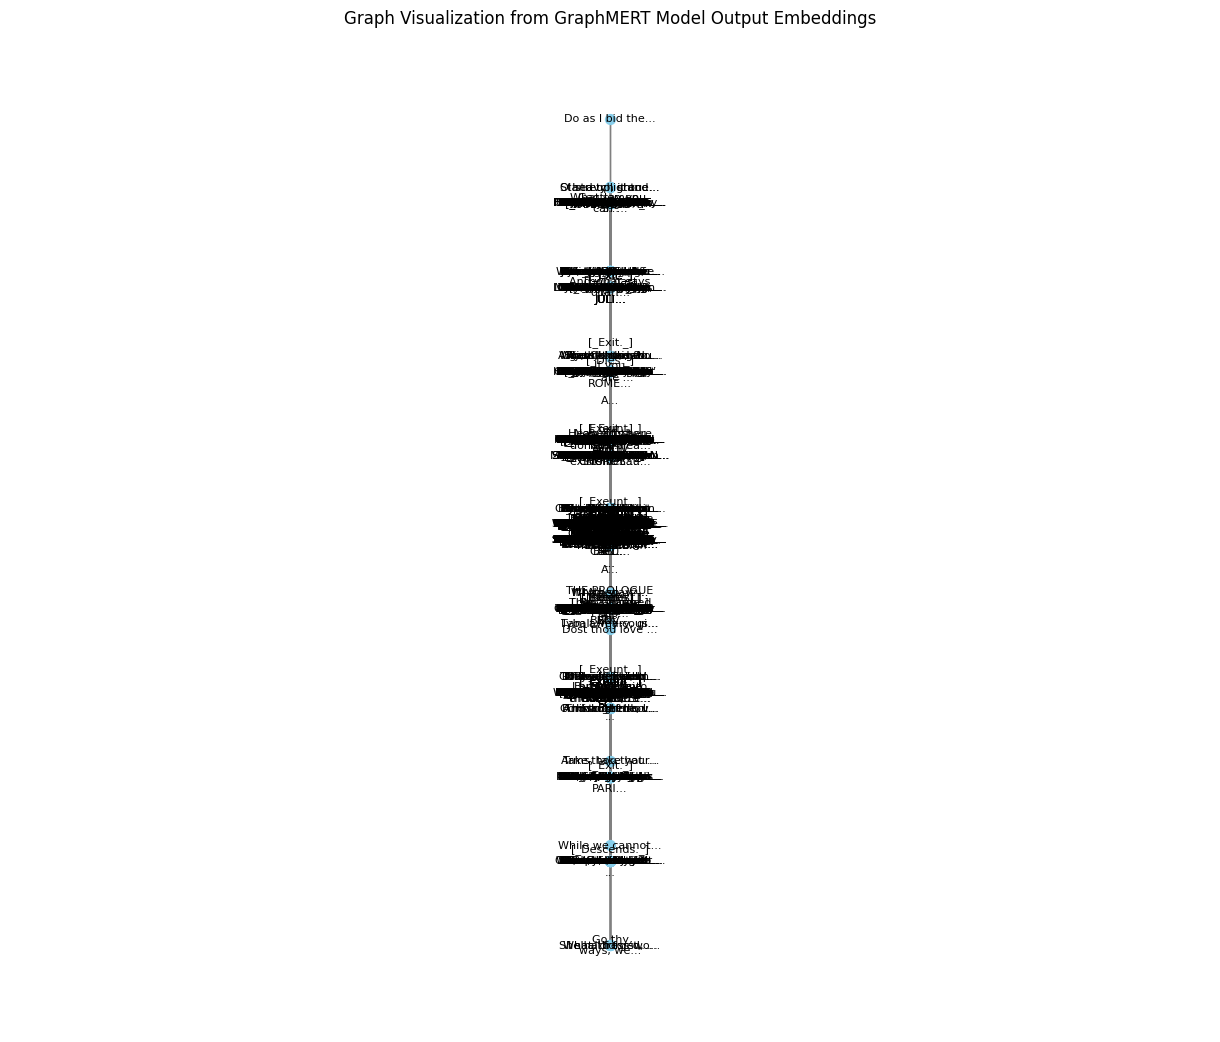

In [ ]:
#  show the graphMERT response to the graphRAG query
import matplotlib.pyplot as plt
import networkx as nx

# Assume 'graphmert_outputs' is your model output tensor: shape (1, num_nodes, 128)
# and 'corpus' holds the corresponding original text chunks

embeddings = graphmert_outputs[0].cpu().numpy()  # (num_nodes, 128)

# Optionally reduce dimensionality with PCA (recommended for large feature sets)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)  # (num_nodes, 2)

# Build graph
G = nx.Graph()

# Add nodes with text and 2D positions for visualization
for i, (text, coord) in enumerate(zip(corpus, emb_2d)):
    G.add_node(i, label=text[:15]+"...", pos=coord)  # label truncated for readability

# Optionally connect sequential nodes or based on proximity for edges
for i in range(len(corpus)-1):
    G.add_edge(i, i+1)

# Get positions for plotting
pos = nx.get_node_attributes(G, 'pos')

# Draw graph with node labels truncated for clarity
plt.figure(figsize=(12,10))
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=50, font_size=8, node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization from GraphMERT Model Output Embeddings")
plt.show()